## Develop Model


## Data Load

Library Imports and Setup

In [2]:
import re
import sqlite3
from pathlib import Path
 
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from pytorch_lightning.utilities.seed import seed_everything
from tqdm import tqdm
 
%matplotlib inline
%config InlineBackend.figure_format='retina'
 
COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]
 
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))
 
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])
 
MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}
 
mpl.rcParams.update(MY_STYLE)
seed_everything(42)

C:\Users\shijie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\utilities\seed.py:104: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
Global seed set to 42


42

In [3]:
connection = sqlite3.connect("bodyfat-new-features.db")
df = pd.read_sql_query("SELECT * FROM bodyfat", connection)

## Data split

Divide the features from the label and split the data into training and test sets:

In [9]:
df.head()

,BodyFat,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI,BAI,WHR
0,12.3,M,23,69.97,1.72,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.651298,23.892776,0.901587
1,6.1,M,22,78.59,1.84,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.213020,21.544894,0.840932
2,25.3,M,22,69.85,1.68,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.748441,27.556227,0.886089
3,10.4,M,26,83.80,1.84,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.751890,22.546538,0.853755
4,28.7,M,24,83.58,1.81,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.512042,23.846228,0.981354


In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["BodyFat"])
y = df["BodyFat"]

# ensure that the proportion of 'Sex' variable is consistent across both the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df["Sex"])
 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((348, 17), (348,), (88, 17), (88,))

In [12]:
X_train.head()

,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI,BAI,WHR
353,F,21,52.6176,1.6510,31.0,81.0,63.5,93.0,48.5,33.0,20.3,25.5,23.7,16.3,19.303537,25.839172,0.682796
301,F,22,67.5864,1.7145,31.0,94.0,74.0,100.0,56.5,36.4,22.0,28.0,25.3,17.5,22.992402,26.544467,0.740000
239,M,65,86.0700,1.6700,40.8,106.4,100.5,100.5,59.2,38.1,24.0,35.9,30.5,19.1,30.861630,28.568404,1.000000
217,M,51,70.0800,1.7800,36.9,93.3,81.5,94.4,54.7,39.0,22.6,27.5,25.9,18.6,22.118419,21.750445,0.863347
140,M,40,80.1700,1.8000,37.4,98.6,93.1,101.6,59.1,39.6,21.6,30.8,27.9,16.6,24.743827,24.071205,0.916339


In [14]:
X_train.Sex.value_counts()

Sex
M    201
F    147
Name: count, dtype: int64

## Preprocessing

Now, I'll scale the numerical features using the StandardScaler from scikit-learn and encode the categorical features using one-hot encoding:

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
 
categorical_features = ["Sex"]
numerical_features = [col for col in X.columns if col not in categorical_features]
 
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()
 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

The data preprocessing pipeline provided by scikit-learn:

- StandardScaler - normalizing numerical inputs ensures that features with larger magnitudes don't disproportionately influence the model, leading to more balanced and effective machine learning algorithms

- OneHotEncoder - One-hot encoding of categorical variables, on the other hand, converts these non-numeric categories into a binary representation, allowing models to use that information without mixing it with ordering, thus enhancing the model's accuracy and interpretability

The 'ColumnTransformer' is used to apply these transformations to the respective feature columns, creating a preprocessor that can be integrated into a machine learning pipeline. 

Let's apply the preprocessing pipeline to our training and test sets:

In [16]:
X_train = preprocessor.fit_transform(X_train)

# The test data must be transformed using the same parameters
X_test = preprocessor.transform(X_test)

Note that we're using the fit_transform method on the training set and the transform method on the test set. This is because we don't want to fit the test set, we want to use the same scaling and encoding as the training set. Let's have a look at the preprocessed data:

In [17]:
X_train.shape

(348, 18)

In [20]:
X_train[0]

array([-0.86457355, -1.32605609, -0.85309475, -1.12112437, -1.23348165,
       -1.33140665, -0.86900364, -1.25710466, -1.61173649, -1.14731999,
       -1.11527746, -0.87830853, -0.51817294, -0.57197435,  0.04306472,
       -1.32016578,  1.        ,  0.        ])

The preprocessor has transformed the Sex column into two additional (one-hot encoded) columns, and the numerical features have been scaled.

## Training Pipeline


When developing machine learning models, it's important to follow a systematic process to maximize the chances of success. The typical process involves the following steps:

- Get as much data as possible
- Get as much compute power as possible
- Throw it all at the problem

This is a good strategy for winning machine learning competitions, but it's not a good strategy for developing production-ready machine learning systems. 

In the real world, we have limited resources and have to be smart about how we use our data, compute power, and time.



We can try a lot of simple models in a short amount of time. We'll use the following models:

In [23]:
!pip install scikit-learn xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 991.0 kB/s eta 0:02:06
   ---------------------------------------- 0.1/124.9 MB 1.2 MB/s eta 0:01:44
   ---------------------------------------- 0.2/124.9 MB 1.2 MB/s eta 0:01:41
   ---------------------------------------- 0.3/124.9 MB 1.4 MB/s eta 0:01:28
   ---------------------------------------- 0.3/124.9 MB 1.4 MB/s eta 0:01:29
   ---------------------------------------- 0.4/124.9 MB 1.4 MB/s eta 0:01:27
   ---------------------------------------- 0.5/124.9 MB 1.4 MB/s eta 0:01:29
   ---------------------------------------- 0.5/124.9 MB 1.4 MB/s eta 0:01:30
   ---------------------------------------- 0.6/124.9 MB 1.5 MB/s eta 0:01:24
   ---------------------------------------- 0.7/124.9 MB 1.5 MB/s eta 0:01:25
   ---------------------------------------- 0.8/124.9 MB 1.5 MB/s eta 0:01:21
   ---------------------------------------- 0.9/124.9 MB 1.5 MB/s eta


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: C:\Users\shijie\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "Huber Regressor": HuberRegressor(max_iter=200),
}

We can use the same training pipeline for all models by using scikit-learn API. 

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

result = []
 
for name, model in tqdm(regressors.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    r2 = r2_score(y_test, y_pred)
    result.append({"model": name, "RMSE": rmse, "R2": r2})

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\shijie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\shijie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 17%|█▋        | 2/12 [00:00<00:01,  6.23it/s]C:\Users\shijie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squa

We fit each model to the training dataset and then predicts outcomes on a test dataset (X_test). For each model, we calculate the root mean squared error (RMSE) and the coefficient of determination (R^2), appending these metrics along with the model's name to the result list:

In [27]:
pd.DataFrame(result).sort_values(by="R2", ascending=False)

,model,RMSE,R2
0,Linear Regression,4.798754,0.688889
2,Gradient Boosting,4.800084,0.688717
11,Huber Regressor,4.816642,0.686565
7,Ridge,4.934344,0.671060
1,Random Forest,4.973306,0.665845
9,AdaBoost Regressor,5.105892,0.647790
10,XGBoost Regressor,5.285572,0.622565
5,K-Nearest Neighbors,5.327401,0.616567
3,Support Vector Regressor,5.747334,0.553737
8,ElasticNet,6.886714,0.359259


Interesingly, the LinearRegression model performs the best - just a simple linear model. Let's evaluate the performance of the model on the test set:

## Evaluation

Create an instance of the LinearRegression model and fit it to the training data:

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [29]:
pd.DataFrame({"prediction": y_pred, "label": y_test}).head(n=10)

,prediction,label
61,23.551926,29.80
97,16.951391,11.30
425,20.518403,29.47
128,18.735429,20.80
304,22.278719,25.44
115,15.819718,16.70
95,17.906050,17.40
179,25.089668,16.90
53,11.373259,6.30
38,50.813203,35.20


Just from a visual inspection, it seems like the model is doing a good job, but there are some outliers. Let's calculate the RMSE and R^2 score on the test set:

In [30]:
r2_score(y_test, y_pred)

0.6888891620486113

In [31]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

C:\Users\shijie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4.798754048152828

Remindar:

- R² Score (Coefficient of Determination)
    - Definition: The R² score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1.
    - Interpretation:
An R² score of 0.6888 means that approximately 68.88% of the variance in the target variable (y_test) is explained by the model.
Higher values indicate better performance, with 1.0 representing a perfect fit.

- RMSE (Root Mean Squared Error)
    - Definition: RMSE measures the square root of the average of the squared differences between the predicted and actual values. It gives an idea of the magnitude of the prediction errors.
    - Interpretation:
An RMSE value of 4.7987 indicates the standard deviation of the residuals (prediction errors) is approximately 4.7987.
Lower RMSE values indicate better model performance.

Plot the predictions vs. the actual values:

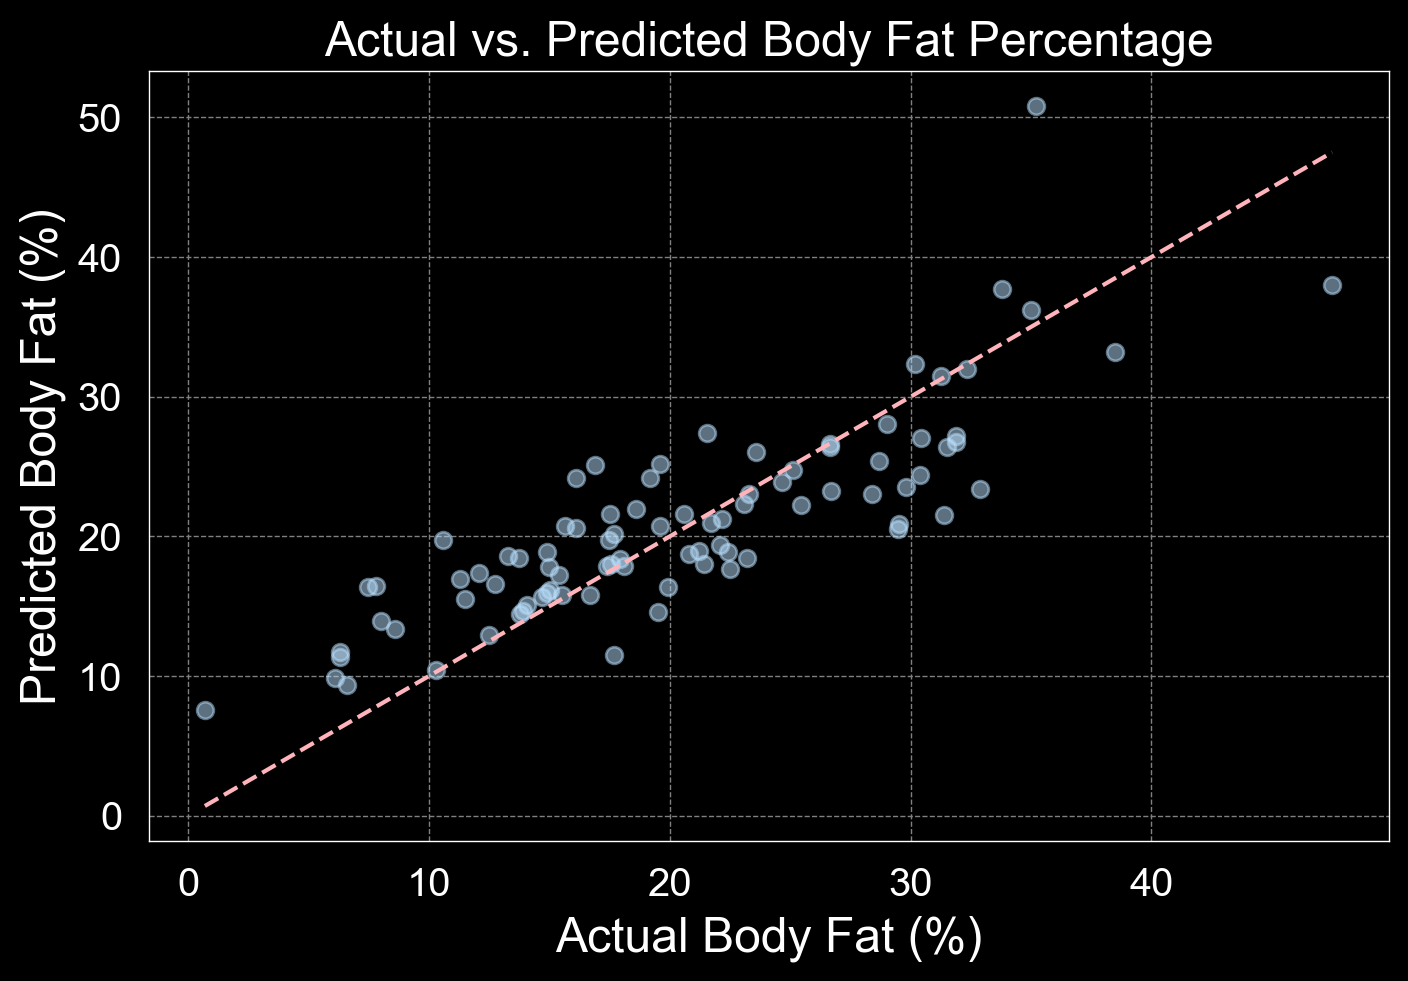

In [32]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("Actual vs. Predicted Body Fat Percentage")
plt.xlabel("Actual Body Fat (%)")
plt.ylabel("Predicted Body Fat (%)")
 
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color=COLORS[1],
    linestyle="--",
)
plt.show()

Looks like our model is predicting higher values for lower actual values of BodyFat. Let's see the distribution of the residuals:

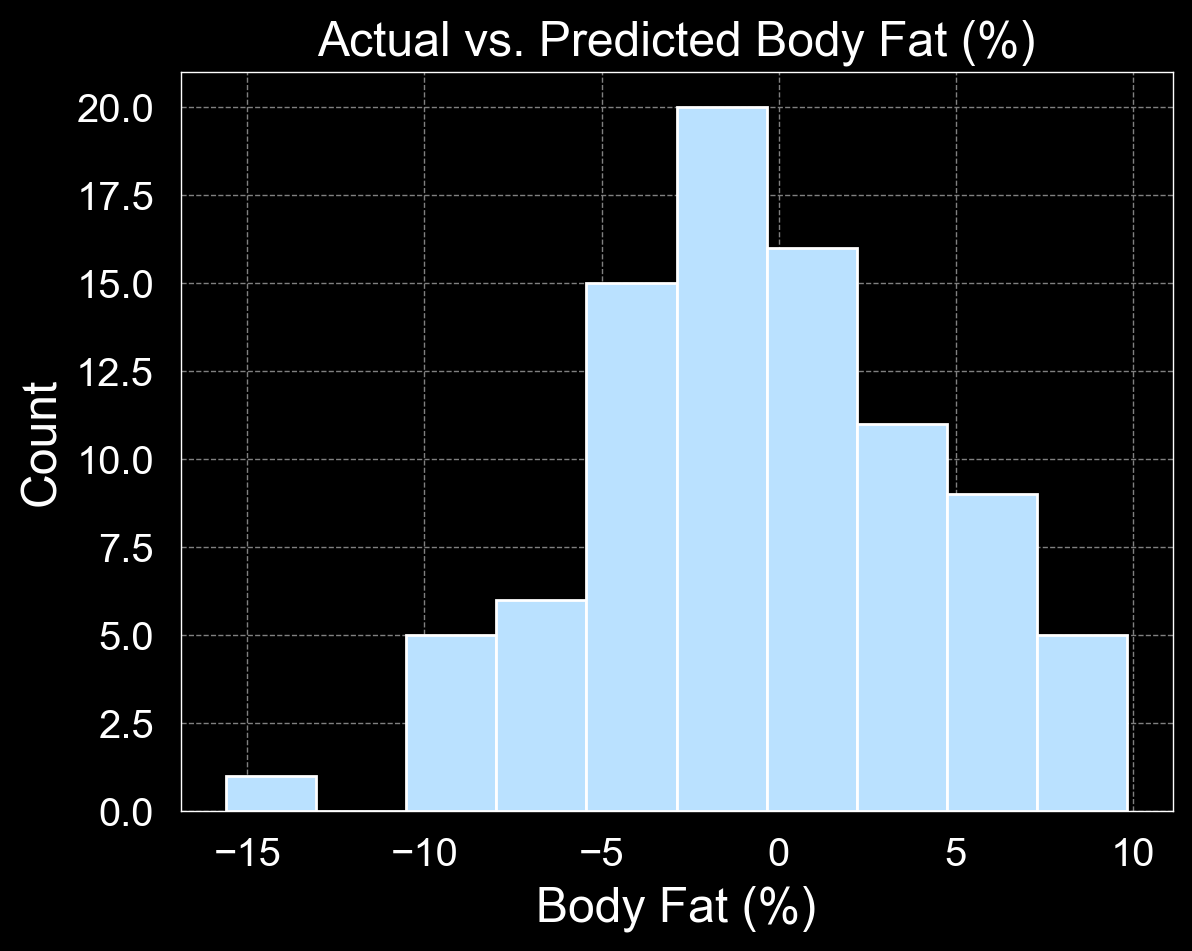

In [33]:
pred_difference = y_test - y_pred
plt.hist(pred_difference)
plt.title("Actual vs. Predicted Body Fat (%)")
plt.xlabel("Body Fat (%)")
plt.ylabel("Count")
plt.show();

### Actionable Steps

The presence of outliers and slight skewness indicates that the model could be improved to handle certain cases better. We can investigate whether they are due to data issues or model limitations. Also, we might want to explore other model types or feature engineering to reduce the spread and skewness of the residuals.

## Save the Pipeline


To have model for later use, we'll wrap the preprocessing pipeline and the model in a single object using the Pipeline class from scikit-learn:

In [35]:
from sklearn.pipeline import Pipeline

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Weight', 'Height',
                                                   'Neck', 'Chest', 'Abdomen',
                                                   'Hip', 'Thigh', 'Knee',
                                                   'Ankle', 'Biceps', 'Forearm',
                                                   'Wrist', 'BMI', 'BAI',
                                                   'WHR']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex'])])),
                ('regressor', LinearRegression())])

Save the pipeline using the pickle library:

In [37]:
import pickle
from pathlib import Path

model_path = Path("model.pkl")
 
with model_path.open("wb") as f:
    pickle.dump(model, f) #serialize a Python object and write it to a file

Now it is all set to deploy our trained model to production. We can use the pickle.load method to load the whole pipeline:

In [38]:
with model_path.open("rb") as f:
    model = pickle.load(f)

In [39]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Weight', 'Height',
                                                   'Neck', 'Chest', 'Abdomen',
                                                   'Hip', 'Thigh', 'Knee',
                                                   'Ankle', 'Biceps', 'Forearm',
                                                   'Wrist', 'BMI', 'BAI',
                                                   'WHR']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex'])])),
                ('regressor', LinearRegression())])

Double check that the loaded pipeline works as expected:

In [40]:
pred = model.predict(X)
rmse = mean_squared_error(y, pred, squared=False)
rmse

C:\Users\shijie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3.973802691335379